In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
merged_data = pd.read_csv('https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true')
merged_data = merged_data.drop(['Item', 'Year'], axis = 1)
merged_data

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [ ]:
# Select features (X) and target variable (y)
features = merged_data[['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)', 'Country']]
target = merged_data['Yield (100 hg/ha)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 42)

In [ ]:
# Create transformers for numeric and categorical features
numeric_features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
categorical_features = ['Country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with scaling, one-hot encoding, and KNN Regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

# Use mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1).fit(X_train, y_train)

# Print the best hyperparameters
print("The best hyperparameters are ", grid_search.best_params_)

The best hyperparameters are  {'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

# Training the KNN model
start_training_time = time.time()
best_model.fit(X_train, y_train)
end_training_time = time.time()
training_time = end_training_time - start_training_time

# Make predictions
start_prediction_time = time.time()
y_pred = best_model.predict(X_test)
end_prediction_time = time.time()
prediction_time = end_prediction_time - start_prediction_time

In [ ]:
# Evaluate the model
r2 = r2_score(y_test, y_pred) # R^2
mae = mean_absolute_error(y_test, y_pred) # mean absolute error
mse = mean_squared_error(y_test, y_pred) # mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False) # root mean squared error
max_err = max_error(y_test, y_pred) # max error
mape = mean_absolute_percentage_error(y_test, y_pred) # mean absolute percentage error

print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Max Error: {max_err:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.5f} seconds")

R-squared (R2): 0.91
Mean Absolute Error (MAE): 5282.52
Mean Squared Error (MSE): 117882412.04
Root Mean Squared Error (RMSE): 10857.37
Max Error: 107554.09
Mean Absolute Percentage Error (MAPE): 0.11%
Training Time: 0.04 seconds
Prediction Time: 0.18351 seconds


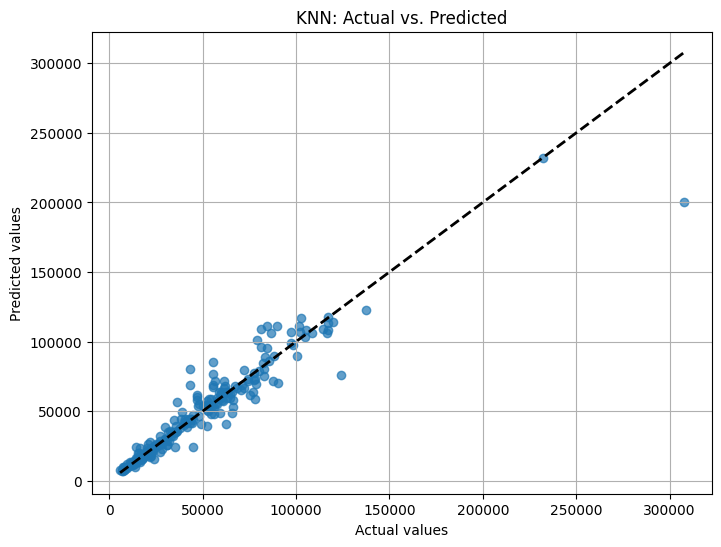

In [ ]:
# Visualize predicted vs actual values on the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('KNN: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()